# Making maps from BLASTTNG

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pygetdata as gd
import subprocess
import os

# Single Channel Maps

## Downloading dirfiles from server, Importing I,Q into magnitude, phase and Δf

In [2]:
#getting files from server from server
# sudo tailscale up before running
def get_kid_timestreams(four_kid_num):
    #four_kid_num must be of the format xxxx, i.e 0001, 0150, 1001
    print(f'Downloading i timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/i_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    print(f'Downloading q timestream kid{four_kid_num}')
    subprocess.run(["scp", 
                    f"player1@cube:/media/player1/blast2020fc1/fc1/extracted/roach3_2020-01-06-06-21-56/q_kid{four_kid_num}_roach3", 
                    "/home/triv/Desktop/localBLASTTNG/roach3_2020-01-06-06-21-56"])
    print('Done')
    return

def targ(chan, dir):
    '''resonant frequency calibration sweep for given chan'''
    # assumes global dir_data and dir_targ
    
    # get list of targ files 
     # sort and remove bottom 4 (not relevant) files
    targ_file_list = os.listdir(dir)
    targ_file_list.sort()
    targ_file_list = targ_file_list[:-4]
    
    # load all targ files data
    dat = np.array([
        np.fromfile(f"{dir}/{f}", dtype = '<f')
        for f in targ_file_list
    ])
    
    # filter data to I and Q data for given channel
    # I = dat[:,chan,1]
    # Q = dat[:,chan,2]
    I = dat[::2,chan]
    Q = dat[1::2,chan]
    
    return I,Q

def Δfx_grad(Q, I, Qf, If):
    '''Calculate Δfx from 'gradient' method
    I: I(t): timestream S21 real component
    Q: Q(t): timestream S21 imaginary component
    If: I(f): frequency sweep S21 real component
    Qf: Q(f): frequency sweep S21 imaginary component'''
    
    dIfdf = np.diff(If)/1e3        # Δx is const. so Δy=dI/df
    dQfdf = np.diff(Qf)/1e3        # /1e3 for units
    dIfdff0 = dIfdf[len(dIfdf)//2] # dI(f)/df at f0
    dQfdff0 = dQfdf[len(dQfdf)//2] # assume f0 is centre index
    I_n = I - np.mean(I)           # centre values on 0
    Q_n = Q - np.mean(Q)           #
    
    den = dIfdff0**2 + dQfdff0**2  # 
    
    numx = ((I_n*dIfdff0 + Q_n*dQfdff0))
    Δfx = numx/den
    
    numy = ((Q_n*dIfdff0 - I_n*dQfdff0))
    Δfy = numy/den
    
    return Δfx

In [3]:
kid_nums = ['0100',
            '0200',
            '0222',
            '0300',
            '0400',
            '0304',
            '0500',
            '0550',
            '0600',
            '0700']

# for i in kid_nums:
#     get_kid_timestreams(i)

In [4]:
#importing from dirfiles

#locations and folder
dir_base = '/home/triv/Desktop/localBLASTTNGdata/'
dir_master = dir_base + 'master_2020-01-06-06-21-22'
dir_roach3 = dir_base + 'roach3_2020-01-06-06-21-56'
dir_targ = dir_base + 'targ_sweep/Mon_Jan__6_06_00_34_2020'

roach_num = 3 #using roach 3 rn

mode_dirfile = gd.RDONLY
data_master = gd.dirfile(dir_master, mode_dirfile)
data_roach3 = gd.dirfile(dir_roach3)

#getting data
RAm = data_master.getdata(b'RA')
DECm = data_master.getdata(b'DEC')
master_time = data_master.getdata(b'TIME') + data_master.getdata(b'TIME_USEC')*1e-6
roach_time = data_roach3.getdata(b'ctime_built_roach3')

#detectors

many_phase_vals = []
many_absIQ_vals = []
many_Δf_vals = []
for n,k_num in enumerate(kid_nums):
    I_vals = data_roach3.getdata(f"i_kid{k_num}_roach3".encode('UTF-8'))
    Q_vals = data_roach3.getdata(f"q_kid{k_num}_roach3".encode('UTF-8'))
    If, Qf = targ(int(k_num) ,dir_targ)
    
    many_absIQ_vals.append(np.sqrt(I_vals**2 + Q_vals**2))
    many_phase_vals.append(np.arctan2(Q_vals, I_vals))
    many_Δf_vals.append(Δfx_grad(Q_vals, I_vals, Qf, If))


many_absIQ_vals = np.array(many_absIQ_vals)
many_phase_vals = np.array(many_phase_vals)
many_Δf_vals = np.array(many_Δf_vals)

def view_data():
    m_diff = np.diff(master_time)
    r_diff = np.diff(roach_time)
    print('RA & DEC shape: ', RAm.shape, DECm.shape)
    print(f"Detector array shape: {many_phase_vals.shape}")
    print(f"Detector Δf shape: {many_Δf_vals.shape}")
    print('Master time: ')
    print(f"    min: {np.min(master_time)}, max: {np.max(master_time)}, avg. diff: {np.mean(m_diff)}, clock speed: {1/np.mean(m_diff)}")
    print('Detector time: ')
    print(f"    min: {np.min(roach_time)}, max: {np.max(roach_time)}, avg. diff: {np.median(r_diff)}, clock speed: {1/np.median(r_diff)}")
    return
view_data()

RA & DEC shape:  (9830900,) (9830900,)
Detector array shape: (10, 46531631)
Detector Δf shape: (10, 46531631)
Master time: 
    min: 1578244880.069792, max: 1578343189.25718, avg. diff: 0.010000020078320739, clock speed: 99.99979921719574
Detector time: 
    min: 1578244917.5798242, max: 1578342886.964096, avg. diff: 0.002048015594482422, clock speed: 488.27753201396973


## Defining Scan area

In [5]:
#setting scan area from RA and DEC master arrays
start = int(7.85e6)
stop = int(7.9722e6)

def show_scan_area():
    plt.scatter(RAm[7000000:7972200], DECm[7000000:7972200])
    plt.scatter(RAm[start:stop], DECm[start:stop])
    plt.show()
#show_scan_area()

#Scaling Master and Detector arrays by time
DETinds = np.array([np.searchsorted(roach_time, t, side='left') for t in master_time]) #finds closest index in roach time for each master time
DETinds[DETinds == len(roach_time)] = len(roach_time) - 1 # fixed max index bug from np.searchsorted

#Scaled arrays (can be used with each other)
RA = RAm[start:stop]
DEC = DECm[start:stop]
PH = many_phase_vals[:,DETinds][:,start:stop]
AMP = many_absIQ_vals[:,DETinds][:,start:stop]
DF = many_Δf_vals[:,DETinds][:,start:stop]

print(f"start: {start}, stop: {stop}")
print("Master: ", RA.shape, DEC.shape) 
print("Detectors: ", PH.shape, AMP.shape, DF.shape)

start: 7850000, stop: 7972200
Master:  (122200,) (122200,)
Detectors:  (10, 122200) (10, 122200) (10, 122200)


## Building Pixel Maps

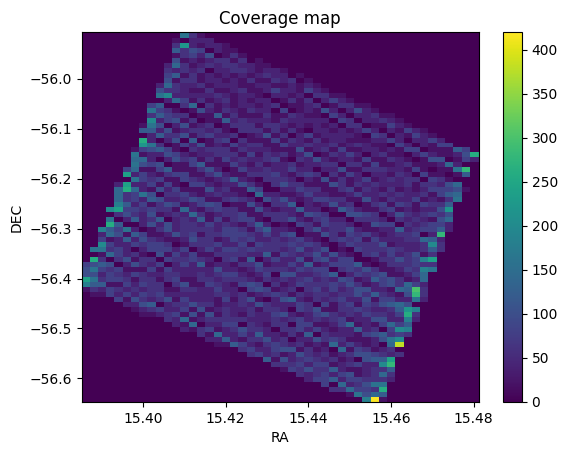

/tmp/ipykernel_22771/2285660103.py:27: RuntimeWarning: Mean of empty slice
  pix_val = np.nanmean(det_vals)


df maps: 10,(74, 48)


In [6]:
#Build map array from pixels
ra_bin = 0.0020 #0.0025
dec_bin = 0.01 #0.02
r_pix = np.arange(np.min(RA), np.max(RA), ra_bin)
d_pix = np.arange(np.min(DEC), np.max(DEC), dec_bin)

rr, dd = np.meshgrid(r_pix,d_pix)

#populate map

def fill_coverage_map():
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            pix_val = det_inds.sum() #counts ra&dec for each pixel
            Z[i,j] = pix_val 
    return Z
 
def fill_map(datastream, kid_n):
    """datastream : PH or AMPS or DF"""
    Z = np.zeros((len(d_pix),len(r_pix)))
    for i in range(len(d_pix)):
        for j in range(len(r_pix)): #loop over pixel map
            det_inds = (RA >= r_pix[j]) & (RA < (r_pix[j] + ra_bin)) & (DEC >= d_pix[i]) & (DEC < (d_pix[i] + dec_bin)) # bining RA and DEC into pixel
            det_vals = datastream[kid_n, det_inds] #data values at each pixel from ts
            pix_val = np.nanmean(det_vals)
            Z[i,j] = pix_val
    return Z

cov_map = fill_coverage_map()

def show_cov_map():
    plt.pcolor(rr,dd,cov_map)
    plt.title('Coverage map')
    plt.xlabel('RA')
    plt.ylabel('DEC')
    plt.colorbar()
    plt.show()
show_cov_map()

phase_maps = [fill_map(PH, kn) for kn in range(len(kid_nums))]
amp_maps = [fill_map(AMP, kn) for kn in range(len(kid_nums))]
df_maps = [fill_map(DF, kn) for kn in range(len(kid_nums))]

print(f"df maps: {len(df_maps)},{df_maps[0].shape}")

In [7]:
%matplotlib inline
def show_multi_maps():
    fig, (axs1, axs2, axs3) = plt.subplots(3, len(kid_nums), sharex=True, sharey=True, figsize=(20,6))
    for i,ax in enumerate(axs1):
        a = axs1[i].pcolor(phase_maps[i])
        b = axs2[i].pcolor(amp_maps[i])
        c = axs3[i].pcolor(df_maps[i])
        axs1[i].set_title(f'kid{kid_nums[i]}')
        fig.colorbar(a)
        fig.colorbar(b)
        fig.colorbar(c)
    
    axs1[0].set_ylabel("Phase Map")
    axs2[0].set_ylabel("Amplitude map")
    axs3[0].set_ylabel("Δf maps")
    fig.tight_layout()
    plt.show()
    #plt.savefig('pixel_map_ph_amp_df_comparision.png')
    
#show_multi_maps()

# Multi Channel maps

### Funcs

In [8]:
from scipy.optimize import curve_fit
from scipy.ndimage import shift
from scipy.ndimage import gaussian_filter
from scipy.ndimage import shift

In [151]:
#functions to handle multiple channels

def standardize_images(listofimages):
    "min-max normalization, 0-1"
    return [(image - np.nanmin(image)) / (np.nanmax(image) - np.nanmin(image)) for image in listofimages]

def flip_images(listofimages):
    def cond1(im):
        #condition for flip, tbd
        return np.nanmedian(im) > 0.5
    return [-1*image + 1 if cond1(image) else image for image in listofimages]

def find_brightest_pixel(image):
    # Find the indices of the maximum value in the 2D array
    indices = np.unravel_index(np.nanargmax(image, axis=None), image.shape)
    return indices

def remove_kid(removekids):
    "enter list like XXXX, i.e [0110, 0555]"
    k_remove_index = []
    for k in removekids:
        try:
            k_remove_index.append(kid_nums.index(k))
            print(f"Removing kid: {removekids}")
        except ValueError:
            print(f'kid{k} already removed')

    for k in k_remove_index:
        kid_nums.pop(k) if k<len(kid_nums)-1 else kid_nums.pop()
        single_channel_maps.pop(k) if k<len(single_channel_maps)-1 else single_channel_maps.pop()
    return


def align_images(images, fit_func):
    # Find the brightest pixel in the reference image
    reference_image = images[0]
    #brightest_pixel_ref = find_brightest_pixel(reference_image)
    #reference_center = fit_gaussian(reference_image)
    reference_center = fit_func(reference_image)

    # Initialize a list to store aligned images
    aligned_images = [reference_image]

    # Iterate through the rest of the images and align them
    shift_amounts = [np.array([0,0])]
    for i in range(1, len(images)):
        current_image = images[i]

        # Find the brightest pixel in the current image
        current_center = fit_func(current_image)
        #print(f"current center : {current_center}")

        # Calculate the shift needed to align the current image with the reference image
        shift_amount = np.array(reference_center) - np.array(current_center)
        #print(f"shift amount : {shift_amount}")

        # Shift the current image
        aligned_image = shift(current_image, shift_amount, cval=np.nan, order=0)

        # Append the aligned image to the list
        aligned_images.append(aligned_image)
        shift_amounts.append(shift_amount)

    return aligned_images, shift_amounts

def show_list_of_images(images, ts_type):
    fig, axs1 = plt.subplots(1, len(images), sharex=True, sharey=True, figsize=(20,4))
    for i,ax in enumerate(axs1):
        a = axs1[i].pcolor(images[i])
        axs1[i].set_title(f'kid{kid_nums[i]}')
        fig.colorbar(a)
    axs1[0].set_ylabel(f"{ts_type}")

    fig.tight_layout()
    plt.show()
    return

def gaussian_2d(xy, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    x, y = xy
    xo = float(xo)
    yo = float(yo)
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude * np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) 
                            + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian(image):
    # Get image dimensions
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    
    # Initial guess for the parameters
    #initial_guess = (np.max(image), np.argmax(image) % image.shape[1], np.argmax(image) // image.shape[1], 2., 2., 0.0, np.min(image))
    initial_guess = (np.max(image), *np.unravel_index(image.argmax(), image.shape)[::-1], 
                     1.2, 1.2, 0, 0.2)
    # print(initial_guess)

    # Fit the 2D Gaussian
    popt, pcov = curve_fit(gaussian_2d, (x, y), image.ravel(), p0=initial_guess)

    # Extract the center coordinates from the fitted parameters
    center_x, center_y = popt[1], popt[2]

    return [center_y, center_x]

## Normalize, View and calibrate images

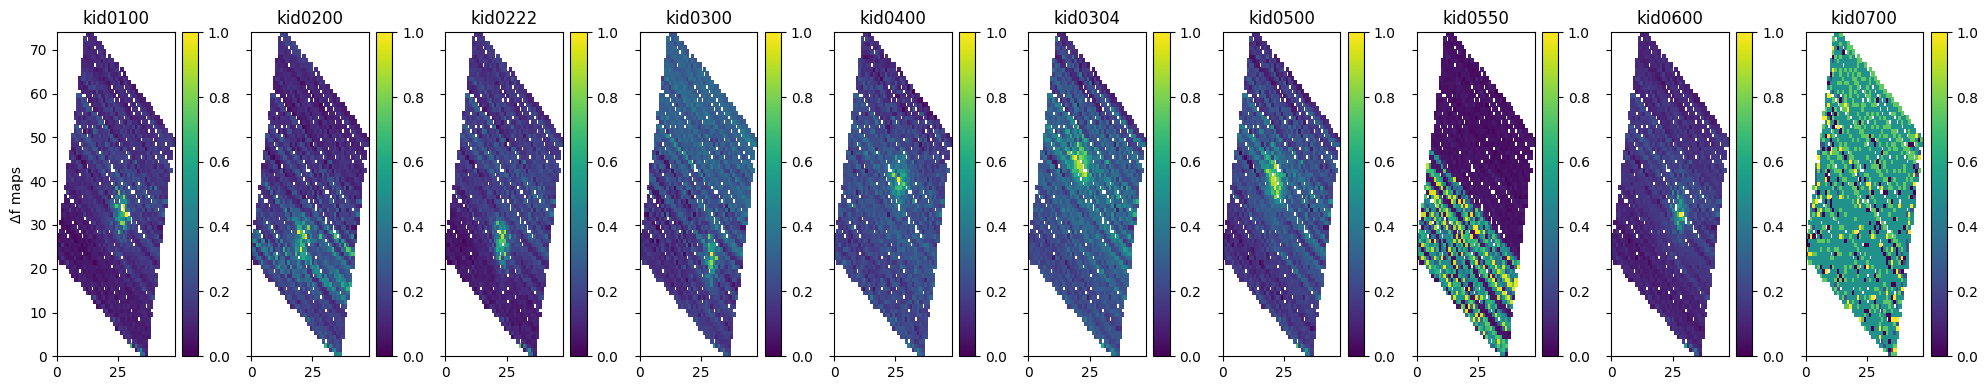

In [11]:
#kid_nums = ['0100','0200','0222','0300','0400','0304','0500','0550','0600','0700']

single_channel_maps = flip_images(standardize_images(df_maps)) # we'll build our multichannel map on delta f, df is flipped and standardized properly

show_list_of_images(single_channel_maps, ts_type='Δf maps')

Removing kid: ['0550', '0700']
Removing kid: ['0550', '0700']


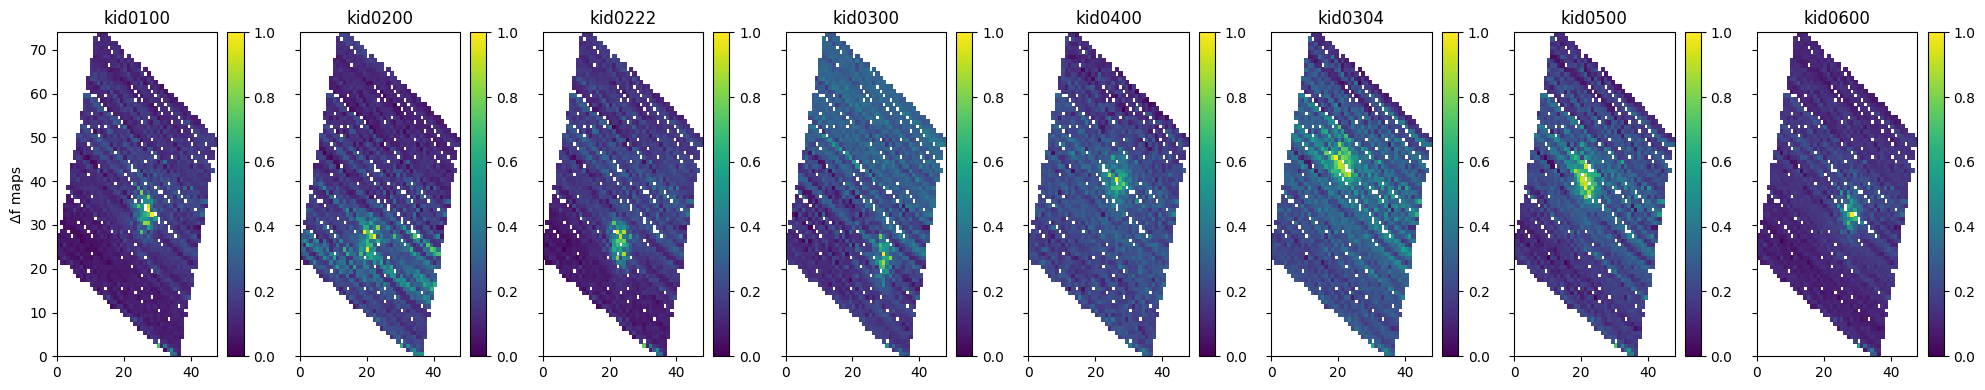

In [12]:
bad_kids = ['0550', '0700']
remove_kid(bad_kids)

show_list_of_images(single_channel_maps, ts_type='Δf maps')

## Building Multi Channel Detector Maps

### Brightest pixel alignment - Median over single channel maps

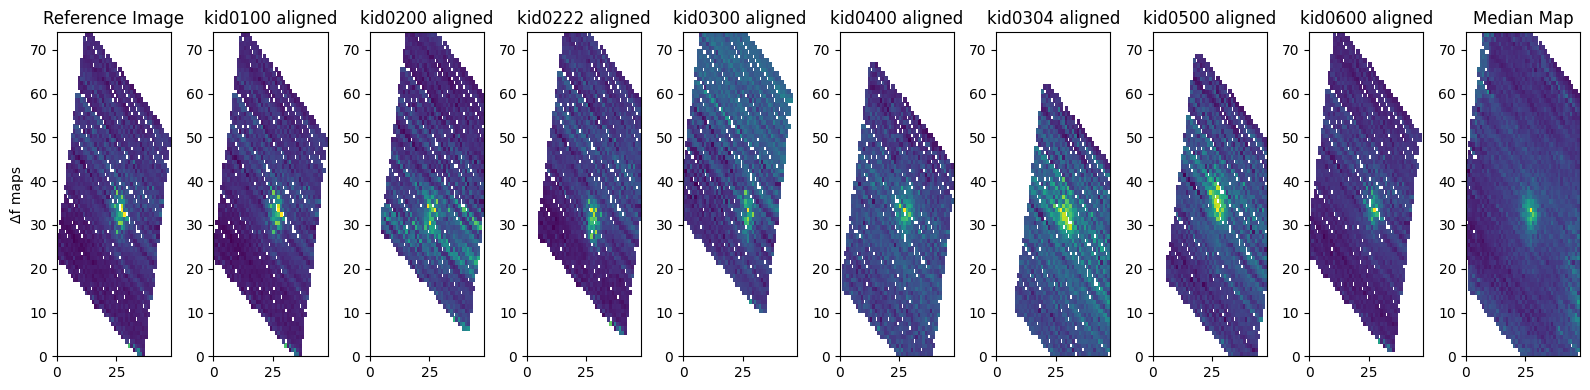

In [153]:
def multiDetectorMap_BrightestPixel():
    # Example usage:
    # images is a list of 2D NumPy arrays representing the astronomical images
    # Make sure all images have the same shape

    # Assuming you have a list of images like this:
    # images = [image1, image2, image3, ...]
    images = single_channel_maps

    def plotMaps(images, aligned_images):

        fig, axs = plt.subplots(1, len(aligned_images) + 2, figsize=(16,4))
        axs[0].pcolor(images[0])
        axs[0].set_title('Reference Image')
        for i, aligned_image in enumerate(aligned_images):
            axs[i+1].pcolor(aligned_image)
            axs[i+1].set_title(f'kid{kid_nums[i]} aligned')
        axs[len(aligned_images) + 1].pcolor(map_med)
        axs[len(aligned_images) + 1].set_title('Median Map')
        axs[0].set_ylabel(f"Δf maps")
        fig.tight_layout()
        plt.show()
    
    # Align the images by brightest pixel and take median map
    aligned_images, shifts = align_images(images, find_brightest_pixel)
    
    map_med = np.nanmedian(np.array(aligned_images), axis=0)
    
    plotMaps(images, aligned_images)

    # # Align the images with 2d gaussian and take median map
    # aligned_images = align_images(images, fit_gaussian)
    # map_med = np.median(aligned_images, axis=0)
    # plotMaps(images, aligned_images)

    return map_med, shifts


map_med_brightest, shifts_brightest = multiDetectorMap_BrightestPixel()

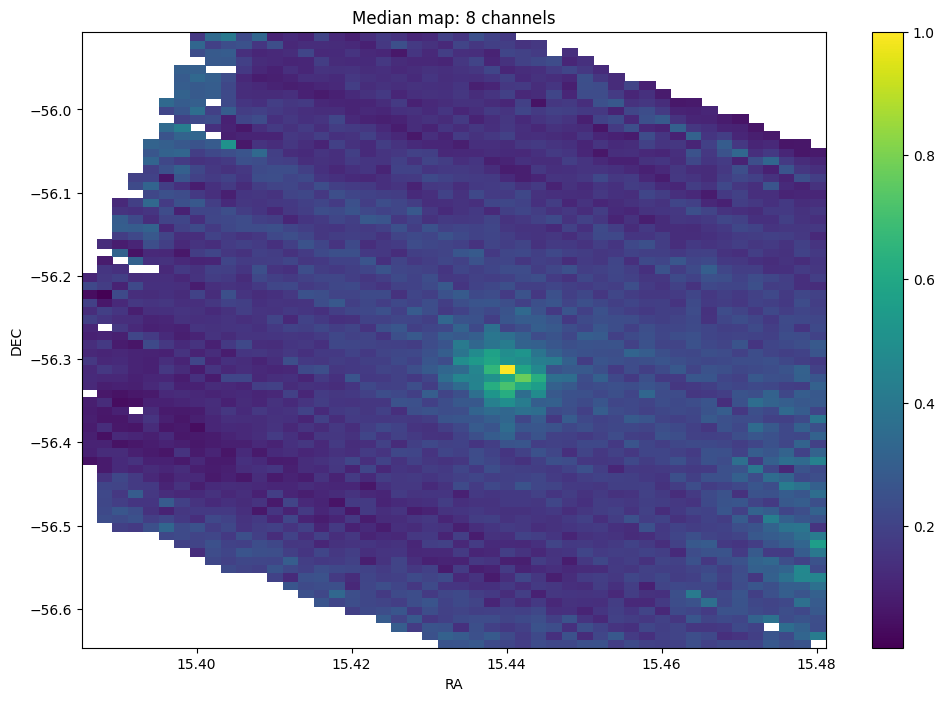

In [170]:
fig, ax = plt.subplots(figsize=(12,8))
m = ax.pcolor(rr,dd,map_med_brightest,cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Median map: {len(single_channel_maps)} channels')
fig.colorbar(m)
plt.show()

#### Predicted KID shifts

In [155]:
#How "far" the other kids are from out reference kid (the first one)
kid_shifts_brightest = dict(zip(kid_nums, shifts_brightest))
kid_shifts_brightest

{'0100': array([0, 0]),
 '0200': array([6, 5]),
 '0222': array([5, 5]),
 '0300': array([10, -2]),
 '0400': array([-7,  1]),
 '0304': array([-12,   8]),
 '0500': array([-5,  6]),
 '0600': array([ 1, -1])}

### Gaussian Fit alignment

#### Convolution using astropy and gaussian alignment

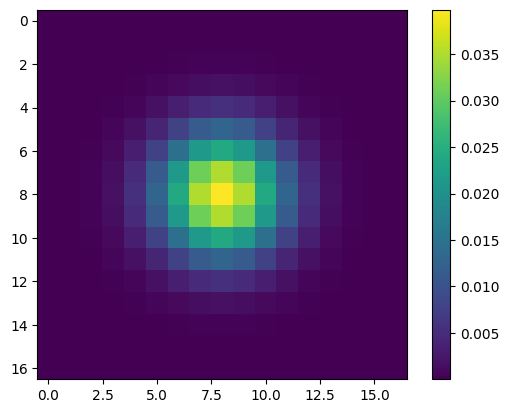

In [157]:
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
# We smooth with a Gaussian kernel with x_stddev=1 (and y_stddev=1)
# It is a 17x17 array
kernel = Gaussian2DKernel(x_stddev=2) #smallest value that removes all the nans

plt.imshow(kernel)
plt.colorbar()

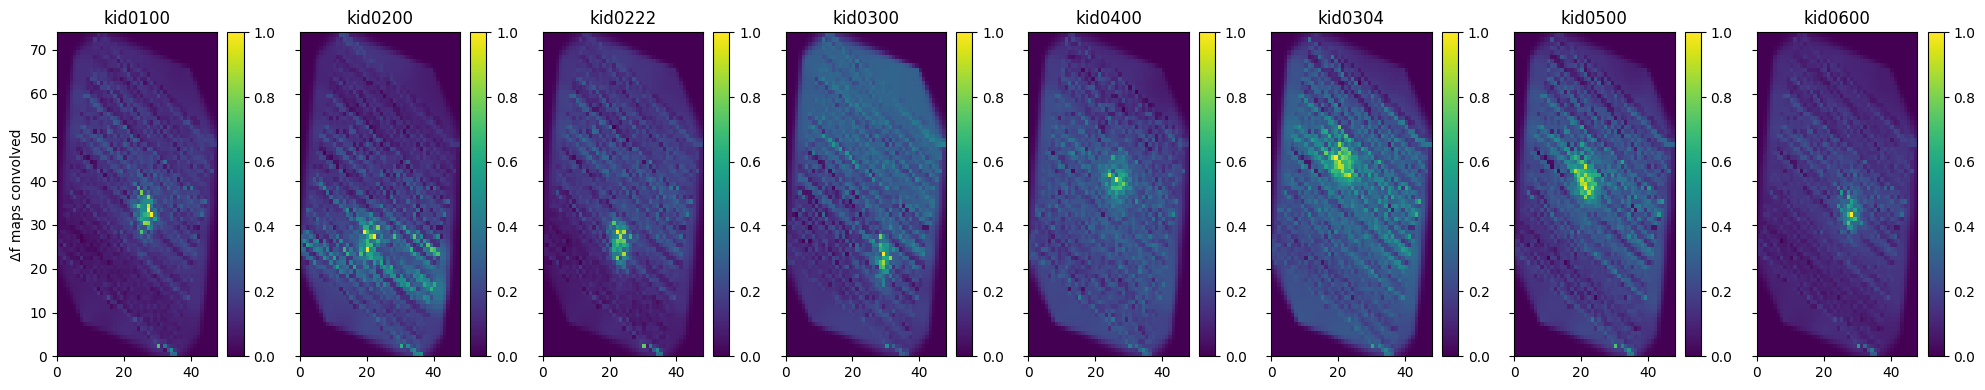

In [158]:
# create a "reconstructed" image with NaNs replaced by interpolated values
convolved_single_channel_maps = [interpolate_replace_nans(ims, kernel) for ims in single_channel_maps]

show_list_of_images(convolved_single_channel_maps, ts_type='Δf maps convolved')

#### Gaussian fit pixel alignment 

26.215035465199424 38.16284072462321
24.264447770654144 23.62624523426021
22.793236576062753 26.143091234985732
28.954542110259997 22.478772276163483
23.688694969896133 33.788314700816215
23.89752692833515 35.42716778376254
24.41109684324333 37.10342236443931
25.66929223915596 36.82755130688638


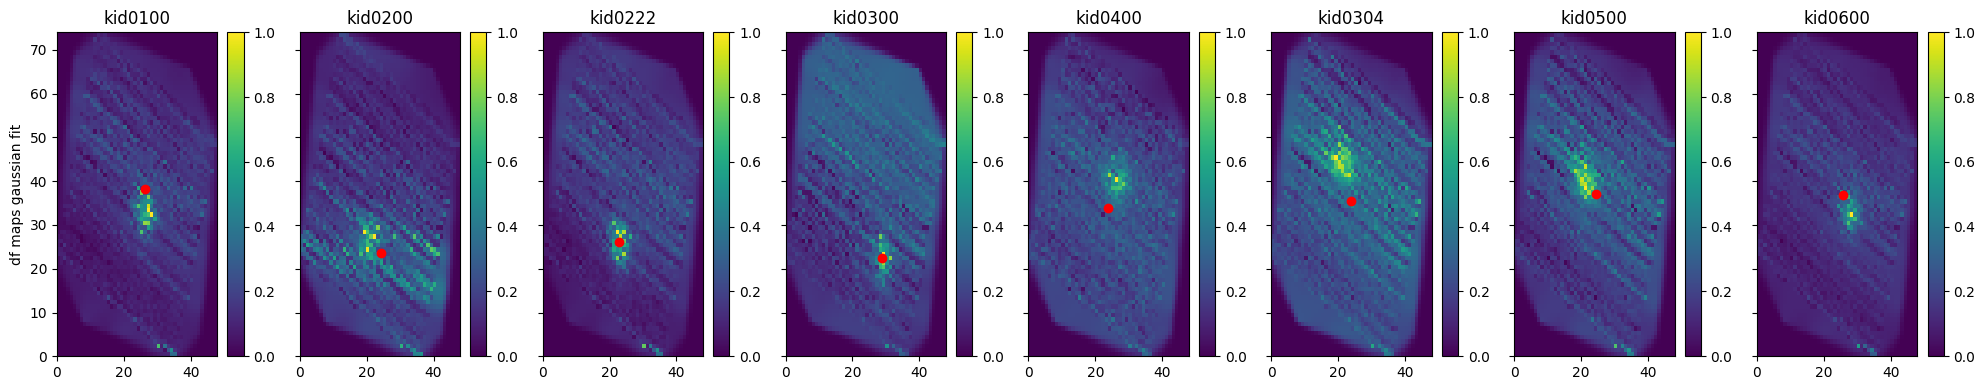

/home/triv/.local/lib/python3.8/site-packages/numpy/lib/nanfunctions.py:1217: RuntimeWarning: All-NaN slice encountered
  return function_base._ureduce(a, func=_nanmedian, keepdims=keepdims,


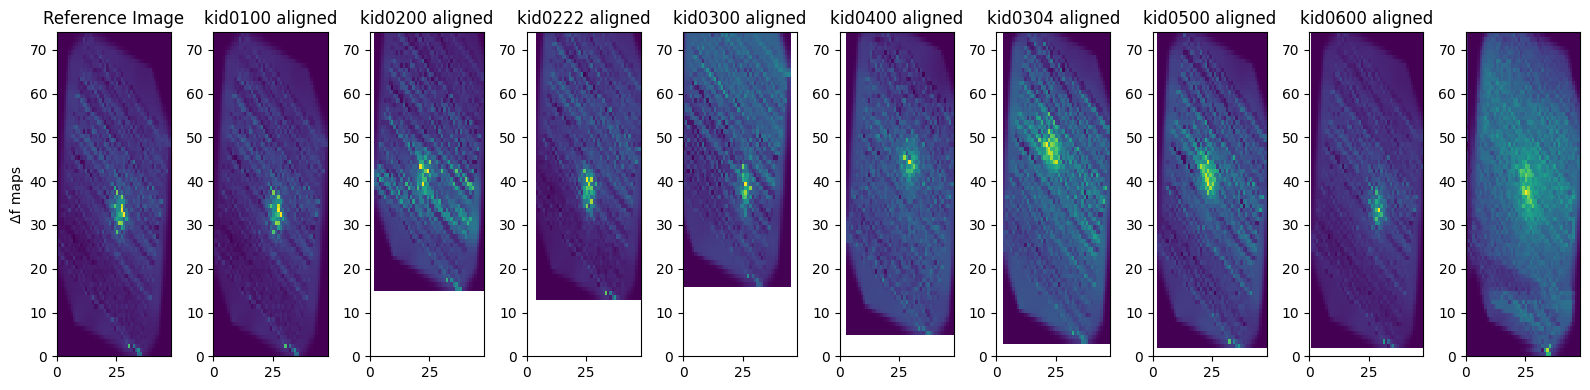

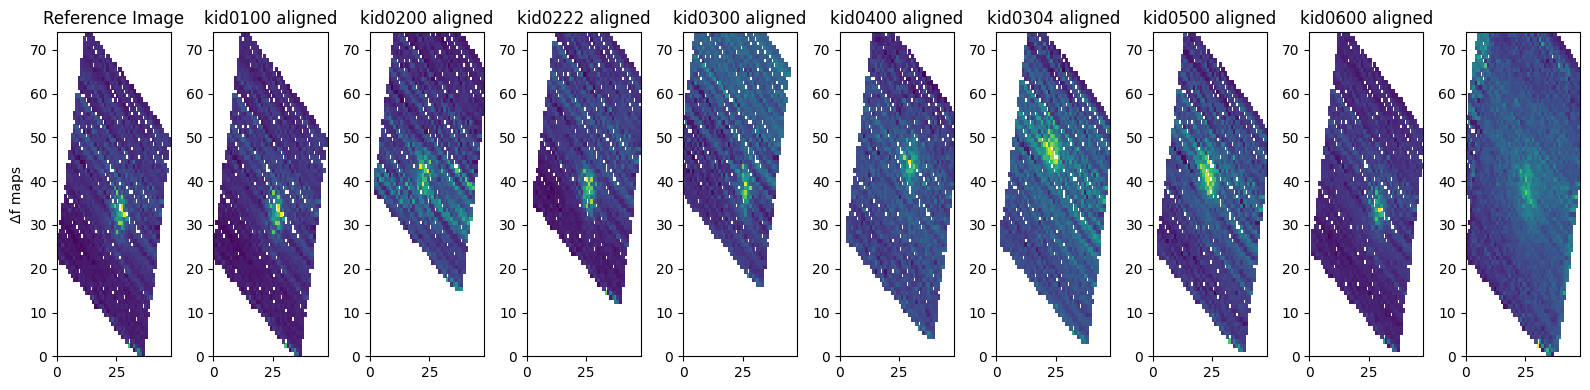

In [168]:
def multiDetectorMap_GaussianAlignment():
    
    images = convolved_single_channel_maps

    fig, axs1 = plt.subplots(1, len(images), sharex=True, sharey=True, figsize=(20,4))
    for i,ax in enumerate(axs1):
        a = axs1[i].pcolor(images[i])
        axs1[i].set_title(f'kid{kid_nums[i]}')
        y, x = fit_gaussian(images[i])
        print(x,y)
        axs1[i].plot(x,y,'or')
        fig.colorbar(a)
    axs1[0].set_ylabel(f"df maps gaussian fit")
    
    fig.tight_layout()
    plt.show()

    def plotMaps(images, aligned_images, extra=False):

        fig, axs = plt.subplots(1, len(aligned_images) + 2, figsize=(16,4))
        axs[0].pcolor(images[0])
        axs[0].set_title('Reference Image')
        for i, aligned_image in enumerate(aligned_images):
            axs[i+1].pcolor(aligned_image)
            axs[i+1].set_title(f'kid{kid_nums[i]} aligned')
        if extra == True:
            axs[len(aligned_images) + 1].pcolor(map_med_gaussfit)
        else:
            axs[len(aligned_images) + 1].pcolor(map_med)
        axs[0].set_ylabel(f"Δf maps")
        fig.tight_layout()
        plt.show()
    
    # Align the images by brightest pixel and take median map
    aligned_images, shifts_gaussfit = align_images(images, fit_gaussian)
    images_shifted = [shift(single_channel_maps[n], np.round(shifts[n]), cval=np.nan, order=0) for n in range(len(single_channel_maps))]
    
    map_med = np.nanmedian(np.array(aligned_images), axis=0)
    map_med_gaussfit = np.nanmedian(np.array(images_shifted), axis=0)
    
    plotMaps(images, aligned_images)
    plotMaps(single_channel_maps, images_shifted, extra=True)

    return map_med_gaussfit, shifts


map_med_gaussfit, shifts_gaussfit = multiDetectorMap_GaussianAlignment()

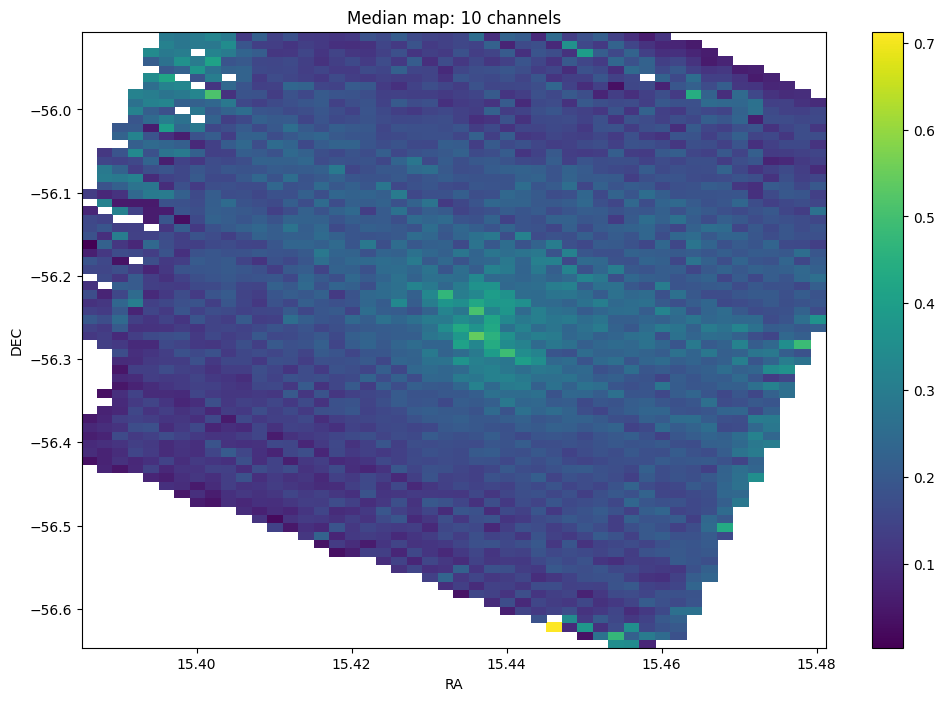

In [169]:
fig, ax = plt.subplots(figsize=(12,8))
m = ax.pcolor(rr,dd,map_med_gaussfit,cmap='viridis')
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.set_title(f'Median map: {len(df_maps)} channels')
fig.colorbar(m)
plt.show()